In [1]:
import cv2
import matplotlib.pyplot as plt
import random
import torch

from PIL import Image
import os
from os.path import isfile
import shutil


from tile_roi_with_labels_wrapper import random_crop_roi_wrapper

Image.MAX_IMAGE_PIXELS = 150000000


def delete_all_files_and_dirs(dir_path):
    # Check if the directory exists
    if not os.path.exists(dir_path):
        raise ValueError(f"The directory {dir_path} does not exist.")
    
    # Iterate over all the contents of the directory
    for filename in os.listdir(dir_path):
        file_path = os.path.join(dir_path, filename)
        
        # Check if it's a file or directory and delete it
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.remove(file_path)
            print(f"Deleted file: {file_path}")
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
            print(f"Deleted directory: {file_path}")
    os.rmdir(dir_path)
            
import torch
torch.cuda.empty_cache()


Create dir and clean up

In [2]:
# print(torchvision.__version__)

parent_dir = "rois2/"
img_dir = parent_dir + "images/"
tile_dir = parent_dir + "tiles/"



if os.path.exists(tile_dir):
    for filename in os.listdir(tile_dir):
        file_path = os.path.join(tile_dir, filename)
            
        # Check if it's a file and delete it
        if os.path.isfile(file_path):
            os.remove(file_path)
            print(f"Deleted file: {file_path}")
if os.path.exists(tile_dir):
    delete_all_files_and_dirs(tile_dir)

Deleted directory: rois2/tiles/labels


load original ROI images

In [3]:
img_paths = []

for root, dirs, files in os.walk(img_dir):
        for file in files:
            if file.lower().endswith(('.jpg','.png')):
                img_path = os.path.join(root, file)
                img_paths.append(img_path)            



In [4]:
test_roi_paths = random.sample(img_paths, len(img_paths) // 10)

print(f"Number of test images: {len(test_roi_paths)}")

for roi_path in test_roi_paths:
    img_paths.remove(roi_path)

with open(img_dir + "train_rois.txt", "w") as f:
    for roi_path in img_paths:
        f.write(roi_path + "\n")
with open(img_dir + "test_rois.txt", "w") as f:
    for roi_path in test_roi_paths:
        f.write(roi_path + "\n")

Number of test images: 47


In [5]:
# Parameters
tile_size = 512  
stride = 256

# ROI images are the smallest bounding box on a rotated ROI. Usually you want to mask out
# the regions that were not in the actualy ROI since these would not have been annotated.
# ROIs in the ROIS.zip file already have these masked out so this is not needed unless
# you would like to change the bounding box color. Note that the text files in boundaries
# folder contains the coordinates of these ROIs. 

fill = (114, 114, 114)  # RGB for a gray color

# How ROI a tile must have, for rotated ROIs, see note above.
boundary_thr = 0.2

# Set how much of box object must be in a tile to be included.
box_thr = 0.8

In [6]:
if not os.path.exists(tile_dir): 
    tiles_df = random_crop_roi_wrapper(
        fps=img_paths,
        save_dir=tile_dir,
        crop_size=tile_size,
        fill=fill,
        box_thr=box_thr
    )
    tiles_df.to_csv(tile_dir + 'tiles dataframe.csv') # Output the dataframe to a .csv file for data analysis
    

100%|██████████| 429/429 [01:13<00:00,  5.86it/s]


In [7]:

positive_cnt = 0
total_cnt = 0
for i in tiles_df['num_boxes']:
    total_cnt += 1
    if i > 0:
        positive_cnt += 1
negative_cnt = total_cnt - positive_cnt
print('positive : negative = ', positive_cnt, ':', negative_cnt , ' = ', positive_cnt/negative_cnt)

positive : negative =  18469 : 18469  =  1.0


1


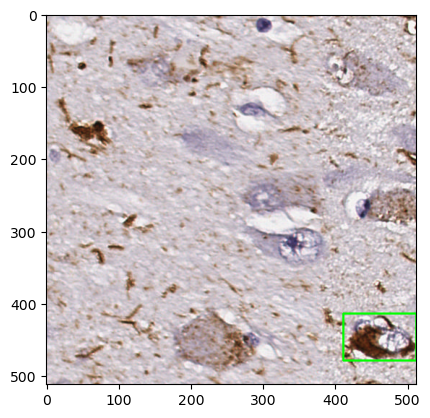

0


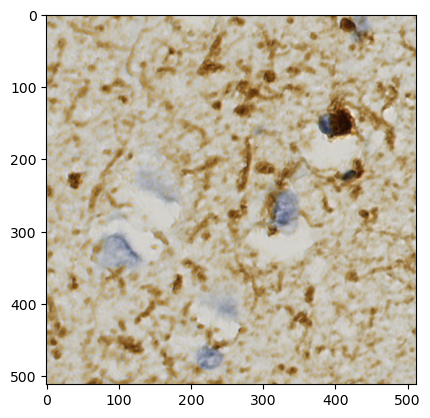

0


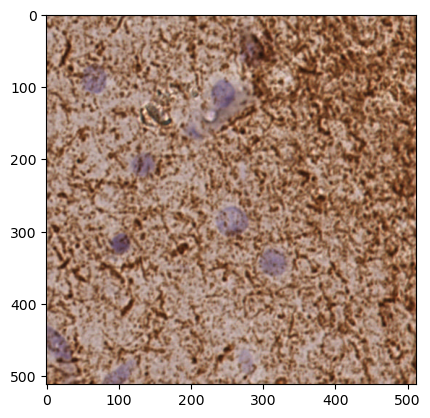

0


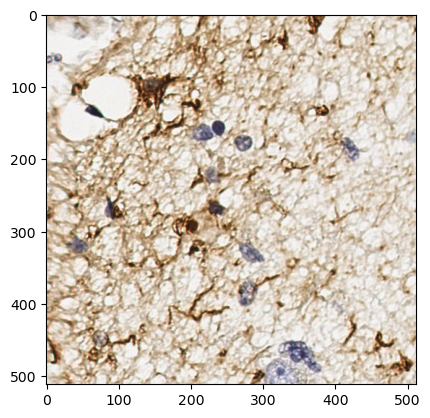

0


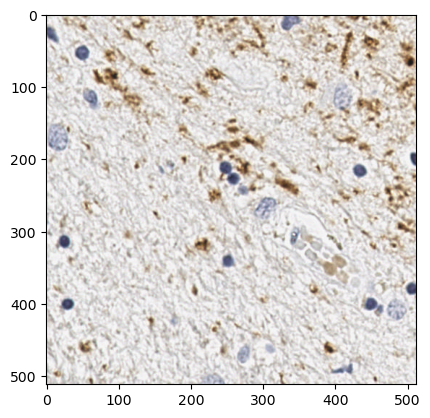

In [8]:
from utils import imread, read_label, im_to_txt_path

def show_img_with_labels(img_fp, label_fp):
    img = imread(img_fp)
    img_size = img.shape[1]
    labels = []
    if isfile(label_fp):
        labels = read_label(label_fp)
        for label in labels:
            # print(label)
            xc, yc, w, h = label[1], label[2], label[3], label[4]
            x1 = int((xc - w/2) * img_size)
            y1 = int((yc - h/2) * img_size)
            x2 = int((xc + w/2) * img_size)
            y2 = int((yc + h/2) * img_size)
            # print(x1, y1, x2, y2)
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    print(len(labels))
    plt.imshow(img)
    plt.show()
        
    
        

crop_dir = tile_dir + 'images/'
crop_paths = []
for tile in tiles_df['fp']:
    if isfile(tile):
        crop_paths.append(tile)
                
random_items = random.sample(crop_paths, 5)

for img in random_items:
    label_fp = im_to_txt_path(img)
    show_img_with_labels(img, label_fp)

calculate mean and sd of images to normalize

In [9]:
import cv2
import numpy as np
import os

input_imgs = []
for root, dirs, files in os.walk(tile_dir + 'images/'):
    for file in files:
        input_imgs.append(root + file)


# Path to your dataset
batch_size = 1000  # Adjust batch size based on your memory capacity
num_batches = len(input_imgs) // batch_size + 1

# Initialize variables to calculate mean and standard deviation
sum_pixel_values = np.zeros(3, np.float64)
sum_squared_pixel_values = np.zeros(3, np.float64)
total_pixels = 0

# Batch processing
for i in range(num_batches + 1):
    batch_files = input_imgs[i * batch_size: min((i + 1) * batch_size, len(input_imgs))]
    
    for image_file in batch_files:
        image = cv2.imread(image_file)
        imge = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image.astype(np.float64) / 255.0  # Scale pixel values to [0, 1]
        
        sum_pixel_values += np.sum(image, axis=(0, 1))
        sum_squared_pixel_values += np.sum(image ** 2, axis=(0, 1))
        total_pixels += image.shape[0] * image.shape[1]

# Calculate the mean
mean = sum_pixel_values / total_pixels

# Calculate the variance and standard deviation
variance = (sum_squared_pixel_values / total_pixels) - (mean ** 2)
std = np.sqrt(variance)

print("Mean:", mean)
print("Standard Deviation:", std)

with open(tile_dir + 'mean_std.txt', 'w') as f:
    f.write(f"Mean: {mean}\n")
    f.write(f"Standard Deviation: {std}\n")

Mean: [0.63990641 0.67864856 0.74857624]
Standard Deviation: [0.23133176 0.20776166 0.17692773]
